### DATA Directory

In [1]:
#Change to match your personal directory on the super-computer
DATA_FILE_PATH=r'C:\Users\Porter\Desktop\SEC Filings\edgar_benchmark'

CRSP_MONTHLY_W_TICKER_PATH=r'C:\Users\Porter\Desktop\SEC Filings\Lazy Prices\crsp_1990-2024_monthly.csv'

FF5_MONTHLY=r"C:\Users\Porter\Desktop\SEC Filings\Lazy Prices\ff5.csv"


### Replication

#### Import packages

In [2]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
# import sf_quant.data as sfd
# import sf_quant.optimizer as sfo
# import sf_quant.backtester as sfb
# import sf_quant.performance as sfp
import datetime as dt
import numpy as np

#for cos similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#progress bar
from tqdm import tqdm

#### Importing Data

In [3]:
SCHEMA_10K_data = {
    # identifiers
    "cik": pl.Int64,# keep as string (leading zeros)
    "cusip": pl.Utf8, # string

    # dates
    "filing_date": pl.Date,

    # 10-K items (always text)
    "Item 1": pl.Utf8,
    "Item 1A": pl.Utf8,
    "Item 1B": pl.Utf8,
    "Item 1C": pl.Utf8,
    "Item 2": pl.Utf8,
    "Item 3": pl.Utf8,
    "Item 4": pl.Utf8,
    "Item 5": pl.Utf8,
    "Item 6": pl.Utf8,
    "Item 7": pl.Utf8,
    "Item 7A": pl.Utf8,
    "Item 8": pl.Utf8,
    "Item 9": pl.Utf8,
    "Item 9A": pl.Utf8,
    "Item 9B": pl.Utf8,
    "Item 10": pl.Utf8,
    "Item 11": pl.Utf8,
    "Item 12": pl.Utf8,
    "Item 13": pl.Utf8,
    "Item 14": pl.Utf8,
    "Item 15": pl.Utf8,
    'year': pl.Int64,
}

SCHEMA_10K_read = {
    # identifiers
    "cik": pl.Int64,# keep as string (leading zeros)
    "cusip": pl.Utf8, # string

    # dates
    "filing_date": pl.Utf8,

    # 10-K items (always text)
    "Item 1": pl.Utf8,
    "Item 1A": pl.Utf8,
    "Item 1B": pl.Utf8,
    "Item 1C": pl.Utf8,
    "Item 2": pl.Utf8,
    "Item 3": pl.Utf8,
    "Item 4": pl.Utf8,
    "Item 5": pl.Utf8,
    "Item 6": pl.Utf8,
    "Item 7": pl.Utf8,
    "Item 7A": pl.Utf8,
    "Item 8": pl.Utf8,
    "Item 9": pl.Utf8,
    "Item 9A": pl.Utf8,
    "Item 9B": pl.Utf8,
    "Item 10": pl.Utf8,
    "Item 11": pl.Utf8,
    "Item 12": pl.Utf8,
    "Item 13": pl.Utf8,
    "Item 14": pl.Utf8,
    "Item 15": pl.Utf8,
}


In [4]:
#init an empty df
data=pl.DataFrame(schema=SCHEMA_10K_data)

for i in range(4,25):
    year=2000+i
    sub=pl.read_parquet(rf'{DATA_FILE_PATH}\{str(year)}_10k_items.parquet',schema=SCHEMA_10K_read)

    #make filing date a pl.date
    sub=sub.with_columns(pl.col('filing_date').cast(pl.Date))

    #make a year col for ez comparision
    sub=sub.with_columns((pl.col('filing_date').dt.year()).alias('year'))
    
    sub=sub.filter(pl.col('year')==year)
    
    data=pl.concat([data,sub],how='vertical_relaxed')


In [5]:
#clean data

#drop null tickers
data=data.filter(pl.col('cusip').is_not_null())

#make cusip length8
data = data.with_columns(
    pl.col("cusip").str.slice(0, 8).alias("cusip8"))

#drop where filing date is null
data=data.filter(pl.col('filing_date').is_not_null())

#make a date column where it is the last day of the month so that we can merge it to the date from CRSP monthly
data=data.with_columns((pl.col('filing_date').dt.month_end()).alias('date'))


#sort ticker ascending and year descending to make operations easier down the line
data = data.sort(
    ["cik", "year"],
    descending=[False, True]
)



#### Similarity Calculation

- Cosine (Equal and TF-IDF weightings)
- Min Edit
- Jaccard
- Simple
- ML/LLM similarity metrics

In [6]:
vectorizer = CountVectorizer(
    lowercase=True,
    token_pattern=r'(?u)\b[a-zA-Z]{2,}\b'
)


In [7]:
cols_to_remove = {'cusip', 'filing_date', 'year', 'date','cik'}
itemlist = [c for c in data.columns if c not in cols_to_remove]
print(itemlist)


['Item 1', 'Item 1A', 'Item 1B', 'Item 1C', 'Item 2', 'Item 3', 'Item 4', 'Item 5', 'Item 6', 'Item 7', 'Item 7A', 'Item 8', 'Item 9', 'Item 9A', 'Item 9B', 'Item 10', 'Item 11', 'Item 12', 'Item 13', 'Item 14', 'Item 15', 'cusip8']


In [8]:
ITEM='Item 1A'

In [9]:
#there is most definitely a faster way to do this, but I am not a CS major so this works for me haha

cik_list=data['cik'].unique().to_list() 
cik_list.sort() #sort it so we match how our data df is

# cik_list = cik_list[:3] #first three for testign

sim_list=[]
for cik in tqdm(cik_list): #this method assumes that my data is sorted on cik and year where cik is increasing and year is decreasing (within cik)
    sub=data.filter(pl.col('cik')==cik) #filter to cik
    year_item=sub.select([ITEM,'year']) #filter to item
    year_list=year_item['year'].to_list() #get a list of the years so we can iterate on it too
    sim_list_cik=[]
    for year in year_list:
        try:
            doc1 = year_item.filter(pl.col('year') == year).select(ITEM).item() #get this year
            doc2 = year_item.filter(pl.col('year') == (year - 1)).select(ITEM).item() #last years item

        except ValueError:
            sim_list_cik.append(None) #when compariing our earliest year to the year before it throws an error, so we append a none (null) value
            continue

        doc_list=[doc1,doc2]
        try:
            X = vectorizer.fit_transform(doc_list) #vectorize it
            similarity = cosine_similarity(X[0], X[1])[0][0] # compute the cos similarity for each to the previous year
        except AttributeError:
            sim_list_cik.append(None) #if a cik is missing item this will get thrown because we will not be able to do cos similarity with a null
            continue


        sim_list_cik.append(similarity)
    sim_list.extend(sim_list_cik) #add all the similarities for the cik to the overall list
    

  0%|          | 1/6285 [00:00<1:06:09,  1.58it/s]

100%|██████████| 6285/6285 [13:02<00:00,  8.03it/s]


In [10]:
#add sim list as a column to data df
data=data.with_columns(pl.Series(f'{ITEM}_cos_sim',sim_list))


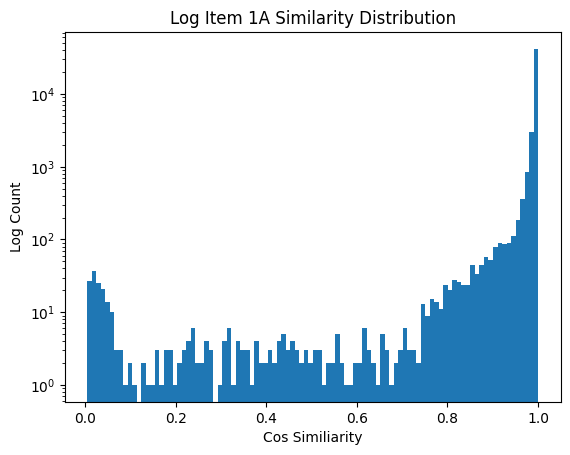

In [34]:
x=data['Item 1A_cos_sim'].to_pandas()

plt.hist(x=x,bins=100, log=True)
plt.title('Log Item 1A Similarity Distribution')
plt.ylabel('Log Count')
plt.xlabel('Cos Similiarity')
plt.show()

#### Portfolio Construction

Load CRSP (pricing data)

In [11]:
#load CRSP data and clean it
crsp = pl.read_csv(
    CRSP_MONTHLY_W_TICKER_PATH,
    schema_overrides={"NCUSIP": pl.Utf8,"CUSIP":pl.Utf8,"RET":pl.Utf8,"RETX":pl.Utf8} #do this so we can load it in and then clean these cols
)

#chat said to use ncusip instead
crsp = crsp.with_columns(
    pl.col("CUSIP").str.slice(0, 8).alias("cusip8")
)

crsp=crsp.with_columns(pl.col('RET').cast(pl.Float32,strict=False)) #make RET a float
# crsp=crsp.with_columns(pl.col('RETX').cast(pl.Float32,strict=False))

#make date a pl.Date
crsp=crsp.with_columns(pl.col('date').cast(pl.Date))
#filter to 10 and 11 sharecode bc that is standard practice
crsp=crsp.filter((pl.col('SHRCD')==10) |(pl.col('SHRCD')==11))

#rename all the cols to lowercase for consistency
crsp = crsp.rename({c: c.lower() for c in crsp.columns})
#get rid of negative price
crsp=crsp.with_columns((pl.col('prc').abs()).alias('prc'))
crsp


permno,date,shrcd,exchcd,ticker,cusip,prc,vol,ret,cusip8
i64,date,i64,i64,str,str,f64,i64,f32,str
10001,1990-01-31,11,3,"""GFGC""","""36720410""",9.9375,353,-0.018519,"""36720410"""
10001,1990-02-28,11,3,"""GFGC""","""36720410""",9.875,149,-0.006289,"""36720410"""
10001,1990-03-30,11,3,"""GFGC""","""36720410""",9.875,127,0.012658,"""36720410"""
10001,1990-04-30,11,3,"""GFGC""","""36720410""",9.875,166,0.0,"""36720410"""
10001,1990-05-31,11,3,"""GFGC""","""36720410""",9.75,279,-0.012658,"""36720410"""
…,…,…,…,…,…,…,…,…,…
93436,2024-08-30,11,3,"""TSLA""","""88160R10""",214.11,16108365,-0.07739,"""88160R10"""
93436,2024-09-30,11,3,"""TSLA""","""88160R10""",261.63,16042065,0.221942,"""88160R10"""
93436,2024-10-31,11,3,"""TSLA""","""88160R10""",249.85001,19014312,-0.045025,"""88160R10"""


In [12]:
#merge CRSP and SEC data
merged=data.join(crsp, on=['date','cusip8'],how='right')

Decile similarity

In [13]:
#sort the data
merged=merged.sort(['permno','date'])


#shift signal to avoid lookahead
merged=merged.with_columns(
    (pl.col(f'{ITEM}_cos_sim').shift(1).over('permno')).alias(f'{ITEM}_cos_sim')
)

#bin similarity
labels=[str(i) for i in range(5)] #make bin labels
merged=merged.with_columns((pl.col(f'{ITEM}_cos_sim').qcut(5,labels=labels,allow_duplicates=True).over('date')).alias('bin'))


Make holding for 3 months

In [14]:
#forward fill the bin from the filing date 3 months so we can have that bin for the holdings

#sort before the forward fill
merged = merged.sort(['permno','date'])

merged = merged.with_columns(
    pl.col("bin").fill_null(strategy="forward", limit=11).over("permno").alias("bin")
)

In [15]:
# merged.filter(pl.col('bin').is_not_null())

In [16]:
#groupby to get the equal weight returns for each bin for each date
ports=merged.group_by(['date','bin']).agg(pl.col('ret').mean())
#drop the null bin
ports=ports.filter(pl.col('bin').is_not_null())
#sort
ports=ports.sort('date','bin')
#pivot so it is easier to do cum returns
ports=ports.pivot('bin',index='date',values='ret')

#add a spread
ports=ports.with_columns(
    (pl.col('4') -pl.col('0')).alias('spread') #hi sim minus low sim
)

Cumluative Returns

In [17]:
#make cum return col for each bin
labels_w_spread=labels+['spread']

for bin in labels_w_spread:
    try:
        ports = ports.with_columns((pl.col(bin).log1p().cum_sum()).alias(f"{bin}_cum_log"))

        
    except Exception: #this is because sometimes we will not have all the bins (this happens when we have the same cutoffs)
        continue

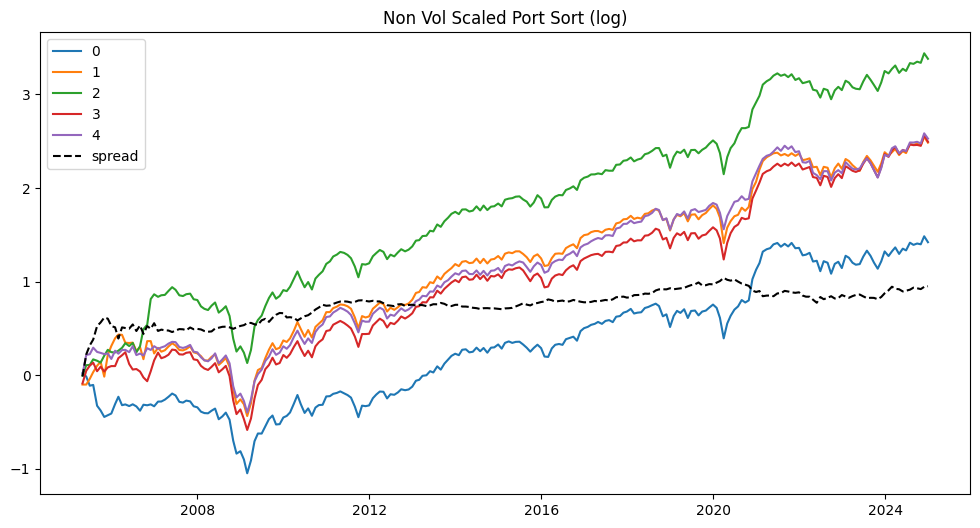

In [18]:
#visualize it
port_pd=ports.to_pandas() #change to pandas so we can plot with mpl
plt.figure(figsize=(12,6))
x=port_pd['date']
#loop thru the bins and plot each of the cum rets

for bin in labels_w_spread:
        try:
            y=port_pd[f'{bin}_cum_log']

            if bin=='spread':
                plt.plot(x,y,label=f'{bin}',linestyle='--',color='black')
            else:
                plt.plot(x,y,label=f'{bin}')
        except Exception:
            continue


plt.legend()
plt.title('Non Vol Scaled Port Sort (log)')
plt.show()


Make Vol Scaled cols

In [19]:
#make vol scaled bin col for each bin
#scale it by rolling annual vol

for bin in labels_w_spread:
    try:
        ports=ports.with_columns(
            (pl.col(bin)/(pl.col(bin).rolling_std(window_size=12).shift(1)*np.sqrt(12))).alias(f'{bin}_vs') #ret divided by the (std times sqrt 12) to scale it to annual vol
        )
    except Exception:
        continue

#make the cumulative vs ports
for bin in labels_w_spread:
    try:
        ports=ports.with_columns(
            (pl.col(f'{bin}_vs').cum_sum()).alias(f'{bin}_vs_cum')
        )
    except Exception:
        continue

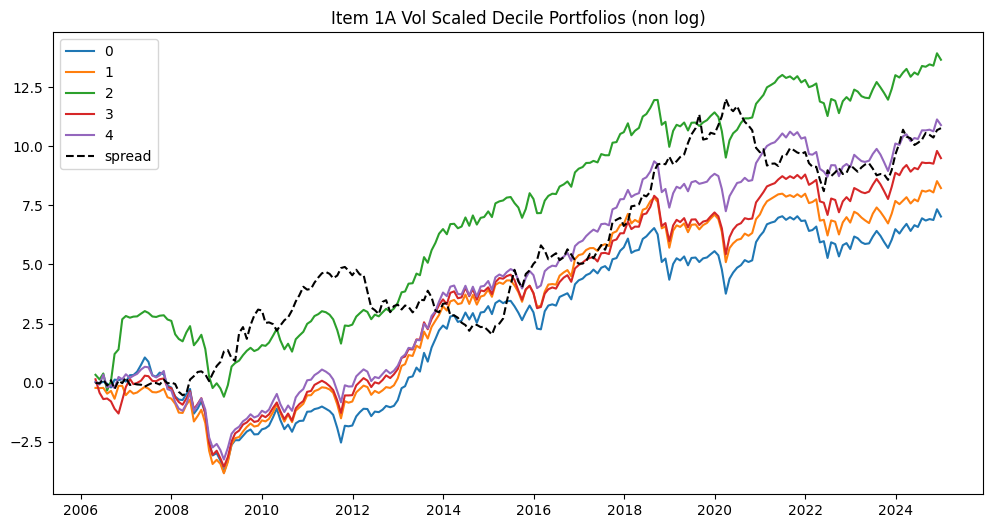

In [20]:
#visualize it
port_pd=ports.to_pandas() #change to pandas so we can plot with mpl
plt.figure(figsize=(12,6))
x=port_pd['date']
#loop thru the bins and plot each of the cum rets
for bin in labels_w_spread:
    try:
        y=port_pd[f'{bin}_vs_cum']
        if bin=='spread':
            plt.plot(x,y,label=f'{bin}',linestyle='--',color='black')
        else:
            plt.plot(x,y,label=f'{bin}')
    except Exception:
        continue

plt.legend()
plt.title(f'{ITEM} Vol Scaled Decile Portfolios (non log)')
plt.show()


FF5 Regression & Residuals

In [21]:
ff5=(pl.read_csv(FF5_MONTHLY)
    # 1) lowercase all column names
    .rename({c: c.lower() for c in pl.read_csv(FF5_MONTHLY).columns})
    # 2) convert YYYYMM -> Date (YYYY-MM-01)
    .with_columns(
        pl.col("date")
        .cast(pl.Utf8)
        .str.strptime(pl.Date, format="%Y%m", strict=False)
        .alias("date")
    )
)
#make the month date month end rather than month start
ff5=ff5.with_columns(
    (pl.col('date').dt.month_end()).alias('date')
)

#ff5 uses percentage, need to convert to decimal divide all numeric by 100
ff5 = ff5.with_columns(
    pl.selectors.numeric() / 100
)



In [22]:
ff5_merged=ports.join(ff5,on=['date'],how='inner')
#getting excess return for each port and then making them cols
for bin in labels:
    try:
        ff5_merged=ff5_merged.with_columns(
            (pl.col(bin)-pl.col('rf')).alias(f'ex_{bin}')
        )
    except Exception:
        continue

#rename mkt-rf to just mkt
ff5_merged=ff5_merged.rename({'mkt-rf':'mkt'})


In [23]:
ff5_merged_pd=ff5_merged.to_pandas()
ff5_merged_pd = ff5_merged_pd.sort_values('date')

#sort ff5_merged_pd
ff5_merged_pd.sort_values('date')
#now do the ff5 regressions

residuals_dict = {}

results_list = []
for b in labels_w_spread:
    try:
        if b=='spread': # we do not need to use ex_spread because (p4-rf) - (p0-rf), the rf will cancel so we can just do p4-p0
            model = smf.ols(
                formula=f'spread ~ mkt + smb + hml + rmw + cma',
                data=ff5_merged_pd
            )
            res = model.fit()
            results_list.append(res)
            residuals_dict[b] = res.resid
        else:
            model = smf.ols(
                formula=f'ex_{b} ~ mkt + smb + hml + rmw + cma',
                data=ff5_merged_pd
            )
            res = model.fit()
            results_list.append(res)
            residuals_dict[b] = res.resid
    except Exception:
        continue




In [24]:
#chats code to make it into a reg table
def results_to_df(results_list, col_names=None, params=None, dec_coef=4, dec_t=2):
    if col_names is None:
        col_names = [f"Model {i+1}" for i in range(len(results_list))]

    if params is None:
        params = ["Intercept", "mkt", "smb", "hml", "rmw", "cma"]

    pretty = {
        "mkt": "MKT",
        "smb": "SMB",
        "hml": "HML",
        "rmw": "RMW",
        "cma": "CMA"
    }

    rows = []

    for p in params:
        row = {"Term": pretty.get(p, p)}

        for name, res in zip(col_names, results_list):
            if p in res.params.index:
                coef = res.params[p]
                t = res.tvalues[p]
                row[name] = f"{coef:.{dec_coef}f} ({t:.{dec_t}f})"
            else:
                row[name] = ""

        rows.append(row)

    return pd.DataFrame(rows).set_index("Term")

# Example:
col_names = [f"Bin {b}" for b in labels_w_spread]
tbl = results_to_df(results_list, col_names=col_names)
tbl


,Bin 0,Bin 1,Bin 2,Bin 3,Bin 4,Bin spread
Term,,,,,,
Intercept,-0.0026 (-1.12),0.0046 (1.97),0.0066 (2.69),0.0027 (1.44),0.0039 (2.31),0.0065 (2.37)
MKT,1.0654 (19.43),1.0918 (19.87),1.0838 (18.75),1.1110 (25.33),0.9985 (24.94),-0.0670 (-1.03)
SMB,0.6887 (7.06),0.8226 (8.42),0.6952 (6.77),0.7678 (9.84),0.8417 (11.83),0.1530 (1.33)
HML,0.1775 (1.83),0.2252 (2.32),0.2043 (2.00),0.0701 (0.91),-0.0282 (-0.40),-0.2057 (-1.80)
RMW,-0.0794 (-0.65),-0.0315 (-0.26),-0.2174 (-1.68),-0.1140 (-1.16),-0.2435 (-2.71),-0.1641 (-1.13)
CMA,0.0263 (0.17),0.0500 (0.32),-0.0667 (-0.40),0.0096 (0.08),-0.0670 (-0.58),-0.0933 (-0.50)


In [25]:
col_names = [b for b in labels_w_spread]

resid_pd = pd.concat(
    {name: res.resid for name, res in zip(col_names, results_list)},
    axis=1
)

resid_pd.index.name = "date"
resid_pd = resid_pd.reset_index()

resid_df = pl.from_pandas(resid_pd)


In [26]:
resid_df

date,0,1,2,3,4,spread
i64,f64,f64,f64,f64,f64,f64
0,-0.094318,-0.068641,0.04762,0.077831,0.162574,0.256892
1,-0.125498,0.017352,-0.03866,0.018624,-0.029064,0.096433
2,-0.184268,0.079518,-0.011885,-0.075618,-0.036146,0.148123
3,-0.053876,0.03229,-0.033117,0.040231,-0.018639,0.035236
4,-0.036243,-0.120939,0.095898,-0.022193,0.0102,0.046443
…,…,…,…,…,…,…
162,0.010629,-0.013857,-0.011162,-0.01339,-0.018469,-0.029098
163,0.003323,-0.001036,-0.005566,-0.012076,0.008649,0.005326
164,0.006393,0.000324,0.006456,-0.013958,-0.009338,-0.015731


In [27]:
# #pl dataframe from dict
# resid_df=pl.DataFrame(residuals_dict
# )
#make a series that is the date
date_series=pl.Series(ff5_merged['date'])

resid_df=resid_df.with_columns(date_series)



#make the cols in log-space
for label in labels_w_spread:
    try:
        resid_df=resid_df.with_columns((pl.col(label).log1p()).alias(label))
    except Exception:
        continue

resid_df

date,0,1,2,3,4,spread
date,f64,f64,f64,f64,f64,f64
2005-05-31,-0.099067,-0.071111,0.046521,0.074951,0.150636,0.228642
2005-06-30,-0.1341,0.017203,-0.039428,0.018453,-0.029495,0.092063
2005-08-31,-0.20367,0.076514,-0.011956,-0.07863,-0.036815,0.138128
2005-09-30,-0.055381,0.03178,-0.033678,0.039442,-0.018815,0.03463
2005-10-31,-0.036916,-0.128901,0.091575,-0.022443,0.010148,0.045397
…,…,…,…,…,…,…
2024-05-31,0.010573,-0.013954,-0.011225,-0.01348,-0.018641,-0.02953
2024-07-31,0.003317,-0.001037,-0.005581,-0.01215,0.008612,0.005312
2024-09-30,0.006373,0.000324,0.006436,-0.014056,-0.009382,-0.015856


In [28]:
#make vol scaled bin col for each bin
#scale it by rolling annual vol
for bin in labels_w_spread:
    try:
        resid_df=resid_df.with_columns(
            (pl.col(bin)/(pl.col(bin).rolling_std(window_size=12).shift(1)*np.sqrt(12))).alias(f'{bin}_vs') #ret divided by the (std times sqrt 12) to scale it to annual vol
        )
    except Exception:
        continue

#make the cumulative vs port
for bin in labels_w_spread:
    try:
        resid_df=resid_df.with_columns(
            (pl.col(f'{bin}_vs').cum_sum()).alias(f'{bin}_vs_cum')
        )
    except Exception:
        continue

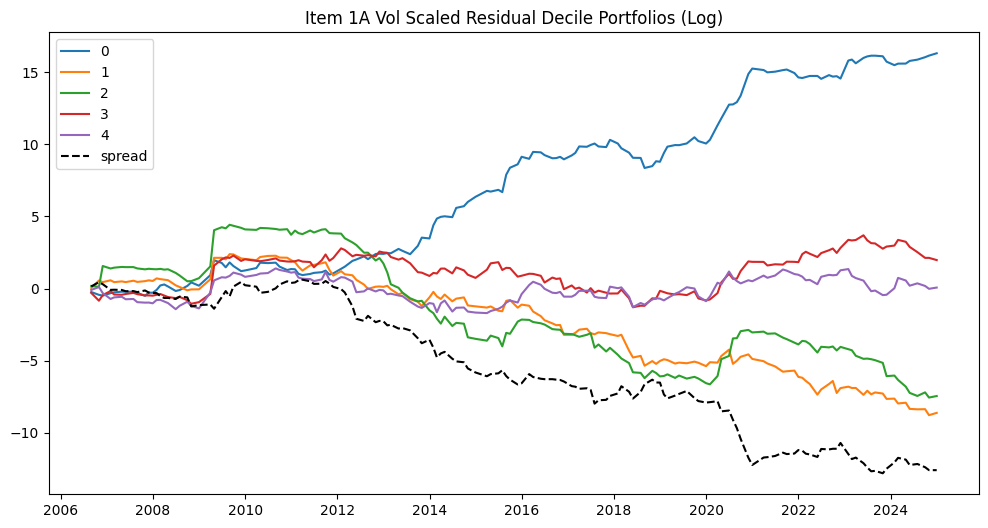

In [29]:
#visualize it
resid_df_pd=resid_df.to_pandas() #change to pandas so we can plot with mpl
plt.figure(figsize=(12,6))
x=resid_df_pd['date']
#loop thru the bins and plot each of the cum rets
for bin in labels_w_spread:
    try:
        y=resid_df_pd[f'{bin}_vs_cum']
        if bin=='spread':
            plt.plot(x,y,label=f'{bin}',linestyle='--',color='black')
        else:
            plt.plot(x,y,label=f'{bin}')
    except Exception:
        continue

plt.legend()
plt.title(f'{ITEM} Vol Scaled Residual Decile Portfolios (Log)')
plt.show()
